In [1]:
import pandas as pd
import numpy as np


In [2]:
sub50 = pd.read_pickle('submission_50.pkl')


In [3]:
t = 'orders'
# t = 'carts'
# t = 'clicks'

sub50['session'] = [int(xx.split('_')[0]) for xx in sub50.session_type]
sub50['type'] = [(xx.split('_')[1]) for xx in sub50.session_type]
sub50 = sub50[sub50.type==t].reset_index(drop=True)
sub50

,session_type,labels,session,type
0,12899779_orders,"[59625, 397451, 469285, 438191, 731692, 737445...",12899779,orders
1,12899780_orders,"[1142000, 736515, 973453, 582732, 1502122, 487...",12899780,orders
2,12899781_orders,"[918667, 199008, 194067, 57315, 141736, 759436...",12899781,orders
3,12899782_orders,"[1007613, 595994, 1033148, 834354, 479970, 169...",12899782,orders
4,12899783_orders,"[1817895, 607638, 1754419, 1216820, 1729553, 3...",12899783,orders
...,...,...,...,...
1671798,14571577_orders,"[1141710, 1276792, 1666114, 86916, 1004292, 36...",14571577,orders
1671799,14571578_orders,"[519105, 977826, 1811714, 822641, 1671592, 815...",14571578,orders
1671800,14571579_orders,"[739876, 1209992, 1550479, 1750859, 785544, 51...",14571579,orders
1671801,14571580_orders,"[202353, 1314576, 433425, 1231403, 871658, 925...",14571580,orders


In [4]:
%%time
train = pd.DataFrame([[i, x, ii] for i, y in zip(sub50.session,sub50.labels)
                    for (ii, x) in enumerate(y)],columns = ['session','aid','rank'])

train

CPU times: user 1min 32s, sys: 10.9 s, total: 1min 43s
Wall time: 1min 43s


,session,aid,rank
0,12899779,59625,0
1,12899779,397451,1
2,12899779,469285,2
3,12899779,438191,3
4,12899779,731692,4
...,...,...,...
75693600,14571581,514866,36
75693601,14571581,1781934,37
75693602,14571581,1651467,38
75693603,14571581,206561,39


In [6]:
1671803*50

83590150

In [7]:
train.session.nunique()

1671803

In [8]:
import pickle
import gensim
ff = open('../w2vmodel/w2vec.pkl','rb')
w2vec = pickle.load(ff)
ff.close()

In [9]:
ff = open(f'ww1clicks_test.pkl','rb')
ww1 = pickle.load(ff)
ff.close()
ff = open(f'ww2carts_test.pkl','rb')
ww2 = pickle.load(ff)
ff.close()
ff = open(f'ww3orders_test.pkl','rb')
ww3 = pickle.load(ff)
ff.close()


In [10]:
def f(x,y):
    try:
        return np.corrcoef(x,y)[0][1]
    except:
        return np.nan
    
def calc_corr(tmp,ww):
    tmp['vec1'] = [ww[xx] if xx in ww else np.array([0]*64) for xx in tmp.session]
    tmp['vec2'] = [w2vec.wv[xx] if xx in w2vec.wv else np.array([0]*64) for xx in tmp.aid]
    return np.array([f(xx,yy) for (xx,yy) in zip(tmp.vec1,tmp.vec2)])

In [12]:

def calc_corr2(tmp,ww):
    tmp['vec1'] = [ww[xx] if xx in ww else np.array([0]*64) for xx in tmp.session]
    tmp['vec2'] = [w2vec.wv[xx] if xx in w2vec.wv else np.array([0]*64) for xx in tmp.aid]
    tmp['vec1mean'] =  np.mean(np.concatenate(tmp.vec1,axis=0).reshape(-1,64),axis=1)
    tmp['vec2mean'] = np.mean(np.concatenate(tmp.vec2,axis=0).reshape(-1,64),axis=1)

    tmp['vec12'] = (tmp['vec1']-tmp['vec1mean'])*(tmp['vec2']-tmp['vec2mean'])
    tmp['vec11'] = (tmp['vec1']-tmp['vec1mean'])*(tmp['vec1']-tmp['vec1mean'])
    tmp['vec22'] = (tmp['vec2']-tmp['vec2mean'])*(tmp['vec2']-tmp['vec2mean'])
    v12 = np.concatenate(tmp.vec12,axis=0).reshape(-1,64)
    v11 = np.concatenate(tmp.vec11,axis=0).reshape(-1,64)
    v22 = np.concatenate(tmp.vec22,axis=0).reshape(-1,64)
    sssss1 = np.mean(v12,axis=1)/np.sqrt(np.mean(v11,axis=1)*np.mean(v22,axis=1))
    return sssss1

In [16]:
from multiprocessing import Pool
import numpy as np

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks'] = np.concatenate(sss1)

  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:10:50,  1.78it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 3/7570 [00:00<23:14,  5.43it/s]  /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  1%|          | 40/7570 [00:02<05:12, 24.08it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  1%|          | 55/7570 [00:02<05:52, 21.31it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1

In [17]:

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww2)
from tqdm import tqdm 
with Pool(10) as p:
    sss2 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_carts'] = np.concatenate(sss2)

  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:18:16,  1.61it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: Runti

In [18]:

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww3)
from tqdm import tqdm 
with Pool(10) as p:
    sss3 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_orders'] = np.concatenate(sss3)

  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:11:16,  1.77it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: Runti

In [19]:
ff = open(f'ww1clicks_last1_test.pkl','rb')
ww1_last1 = pickle.load(ff)
ff.close()
ff = open(f'ww2carts_last1_test.pkl','rb')
ww2_last1 = pickle.load(ff)
ff.close()
ff = open(f'ww3orders_last1_test.pkl','rb')
ww3_last1 = pickle.load(ff)
ff.close()


In [20]:

def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last1)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last1'] = np.concatenate(sss1)



def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww2_last1)
from tqdm import tqdm 
with Pool(10) as p:
    sss2 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_carts_last1'] = np.concatenate(sss2)



  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:29:21,  1.41it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 11/7570 [00:00<07:47, 16.18it/s] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 25/7570 [00:01<06:40, 18.86it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  1%|          | 47/7570 [00:02<05:43, 21.90it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1

In [21]:
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww3_last1)
from tqdm import tqdm 
with Pool(10) as p:
    sss3 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_orders_last1'] = np.concatenate(sss3)


  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:34:07,  1.34it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: Runti

In [22]:
ff = open(f'ww1clicks_last2_test.pkl','rb')
ww1_last2 = pickle.load(ff)
ff.close()


def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last2)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last2'] = np.concatenate(sss1)



  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 11/7570 [00:00<09:02, 13.93it/s] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  1%|          | 44/7570 [00:02<05:55, 21.15it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  1%|          | 54/7570 [00:02<06:09, 20.37it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in tr

In [23]:

ff = open(f'ww1clicks_last3_test.pkl','rb')
ww1_last3 = pickle.load(ff)
ff.close()
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last3)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last3'] = np.concatenate(sss1)


  0%|          | 1/7570 [00:00<1:15:42,  1.67it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 11/7570 [00:00<07:19, 17.18it/s] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 14/7570 [00:01<06:56, 18.14it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 21/7570 [00:01<05:52, 21.40it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encount

In [24]:

ff = open(f'ww1clicks_last5_test.pkl','rb')
ww1_last5 = pickle.load(ff)
ff.close()
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last5)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last5'] = np.concatenate(sss1)


  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:16:53,  1.64it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 11/7570 [00:00<08:51, 14.23it/s] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 21/7570 [00:01<06:28, 19.45it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in t

In [25]:




ff = open(f'ww1clicks_last10_test.pkl','rb')
ww1_last10 = pickle.load(ff)
ff.close()
def f(ii):
    return calc_corr2(train[ii*10000:(ii+1)*10000].reset_index(drop=True),ww1_last10)
from tqdm import tqdm 
with Pool(10) as p:
    sss1 = list(tqdm(iterable=(p.imap(f, range(int(len(train)/10000)+1))), total=int(len(train)/10000)+1))
train['sim_clicks_last10'] = np.concatenate(sss1)


  0%|          | 0/7570 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 1/7570 [00:00<1:22:20,  1.53it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 11/7570 [00:00<08:18, 15.17it/s] /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  0%|          | 21/7570 [00:01<06:05, 20.64it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
  1%|          | 41/7570 [00:02<05:45, 21.81it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1

In [5]:
train.columns

Index(['session', 'aid', 'rank'], dtype='object')

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [17]:
user_features = pd.read_parquet('user_features_test.pqt').reset_index()
item_features = pd.read_parquet('item_features_test.pqt').reset_index()
user_item_features = pd.read_parquet('user_item_features_test.pqt').reset_index()

In [20]:
user_features

,session,user_count,user_item_count,user_buy_ratio,user_clicks_count,user_clicks_item_count,user_carts_count,user_carts_item_count,user_orders_count,user_orders_item_count
0,12899779,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1,12899780,5,4,1.000000,5.0,4.0,NaN,NaN,NaN,NaN
2,12899781,11,5,1.454545,10.0,5.0,1.0,1.0,NaN,NaN
3,12899782,70,38,2.371429,46.0,32.0,16.0,14.0,8.0,8.0
4,12899783,11,9,1.000000,11.0,9.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1671798,14571577,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1671799,14571578,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1671800,14571579,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN
1671801,14571580,1,1,1.000000,1.0,1.0,NaN,NaN,NaN,NaN


In [21]:
item_features

,aid,item_count,item_user_count,item_buy_ratio,item_clicks_count,item_clicks_user_count,item_carts_count,item_carts_user_count,item_orders_count,item_orders_user_count
0,0,48,40,1.000000,48,40,NaN,NaN,NaN,NaN
1,1,34,30,1.147059,33,29,1.0,1.0,NaN,NaN
2,2,17,16,1.000000,17,16,NaN,NaN,NaN,NaN
3,3,2759,1392,1.401232,2513,1392,205.0,173.0,41.0,36.0
4,4,221,143,1.203620,212,143,9.0,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1855598,1855598,7,7,1.000000,7,7,NaN,NaN,NaN,NaN
1855599,1855599,14,12,1.000000,14,12,NaN,NaN,NaN,NaN
1855600,1855600,91,57,1.406593,83,57,7.0,7.0,1.0,1.0
1855601,1855601,92,62,1.380435,85,60,7.0,7.0,NaN,NaN


In [22]:
user_item_features

,session,aid,user_item_int_count,user_item_int_clicks_count,user_item_int_carts_count,user_item_int_orders_count
0,12899779,59625,1,1.0,NaN,NaN
1,12899780,582732,1,1.0,NaN,NaN
2,12899780,736515,1,1.0,NaN,NaN
3,12899780,973453,1,1.0,NaN,NaN
4,12899780,1142000,2,2.0,NaN,NaN
...,...,...,...,...,...,...
5006552,14571577,1141710,1,1.0,NaN,NaN
5006553,14571578,519105,1,1.0,NaN,NaN
5006554,14571579,739876,1,1.0,NaN,NaN
5006555,14571580,202353,1,1.0,NaN,NaN


In [23]:
train = pd.merge(train,user_features,how='left',on='session')
train = pd.merge(train,item_features,how='left',on='aid')
train = pd.merge(train,user_item_features,how='left',on=['session','aid'])


In [24]:
train = pd.merge(train,train_sim,how='left',on=['session','aid'])


In [25]:
train.shape

(75693605, 35)

In [26]:
user_features.columns

Index(['session', 'user_count', 'user_item_count', 'user_buy_ratio',
       'user_clicks_count', 'user_clicks_item_count', 'user_carts_count',
       'user_carts_item_count', 'user_orders_count', 'user_orders_item_count'],
      dtype='object')

In [27]:
item_features.shape

(1855603, 10)

In [28]:
user_item_features.shape

(5006557, 6)

In [31]:
features = ['rank', 'user_count', 
        'sim_clicks','sim_carts', 'sim_orders',
        'sim_clicks_last1', 'sim_carts_last1','sim_orders_last1',
        'sim_clicks_last2', 'sim_clicks_last3','sim_clicks_last5', 'sim_clicks_last10',
       'user_item_count', 'user_buy_ratio', 'user_clicks_count',
       'user_clicks_item_count', 'user_carts_count', 'user_carts_item_count',
       'user_orders_count', 'user_orders_item_count', 'item_count',
       'item_user_count', 'item_buy_ratio', 'item_clicks_count',
       'item_clicks_user_count', 'item_carts_count', 'item_carts_user_count',
       'item_orders_count', 'item_orders_user_count', 'user_item_int_count',
       'user_item_int_clicks_count', 'user_item_int_carts_count',
       'user_item_int_orders_count']

In [32]:
t

'orders'

In [35]:
import pickle
ff = open(f'lgb_modellist_{t}','rb')

modellist = pickle.load(ff)
ff.close()

In [38]:
features

['rank',
 'user_count',
 'sim_clicks',
 'sim_carts',
 'sim_orders',
 'sim_clicks_last1',
 'sim_carts_last1',
 'sim_orders_last1',
 'sim_clicks_last2',
 'sim_clicks_last3',
 'sim_clicks_last5',
 'sim_clicks_last10',
 'user_item_count',
 'user_buy_ratio',
 'user_clicks_count',
 'user_clicks_item_count',
 'user_carts_count',
 'user_carts_item_count',
 'user_orders_count',
 'user_orders_item_count',
 'item_count',
 'item_user_count',
 'item_buy_ratio',
 'item_clicks_count',
 'item_clicks_user_count',
 'item_carts_count',
 'item_carts_user_count',
 'item_orders_count',
 'item_orders_user_count',
 'user_item_int_count',
 'user_item_int_clicks_count',
 'user_item_int_carts_count',
 'user_item_int_orders_count']

In [41]:
train.head()

,session,aid,rank,user_count,user_item_count,user_buy_ratio,user_clicks_count,user_clicks_item_count,user_carts_count,user_carts_item_count,...,sim_clicks,sim_carts,sim_orders,sim_clicks_last1,sim_carts_last1,sim_orders_last1,sim_clicks_last2,sim_clicks_last3,sim_clicks_last5,sim_clicks_last10
0,12899779,59625,0,1,1,1.0,1.0,1.0,NaN,NaN,...,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000
1,12899779,397451,1,1,1,1.0,1.0,1.0,NaN,NaN,...,0.952355,NaN,NaN,0.952355,NaN,NaN,0.952355,0.952355,0.952355,0.952355
2,12899779,469285,2,1,1,1.0,1.0,1.0,NaN,NaN,...,0.933419,NaN,NaN,0.933419,NaN,NaN,0.933419,0.933419,0.933419,0.933419
3,12899779,438191,3,1,1,1.0,1.0,1.0,NaN,NaN,...,0.753977,NaN,NaN,0.753977,NaN,NaN,0.753977,0.753977,0.753977,0.753977
4,12899779,731692,4,1,1,1.0,1.0,1.0,NaN,NaN,...,0.903594,NaN,NaN,0.903594,NaN,NaN,0.903594,0.903594,0.903594,0.903594


In [42]:
import lightgbm as lgb
from lightgbm.sklearn import LGBMRanker
import numpy as np
from tqdm import tqdm
from catboost import CatBoostClassifier,CatBoostRanker,Pool

oof_predictions = np.zeros(train.shape[0])

for model in modellist:
    oof_predictions_part = np.zeros(train.shape[0])
    for ii in tqdm(range(int(len(train)/100000)+1)):
        oof_predictions_part[ii*100000:(ii+1)*100000] = \
                        model.predict(train[ii*100000:(ii+1)*100000][features])
    oof_predictions = oof_predictions+oof_predictions_part/len(modellist)
    
    

100%|██████████| 757/757 [03:10<00:00,  3.96it/s]


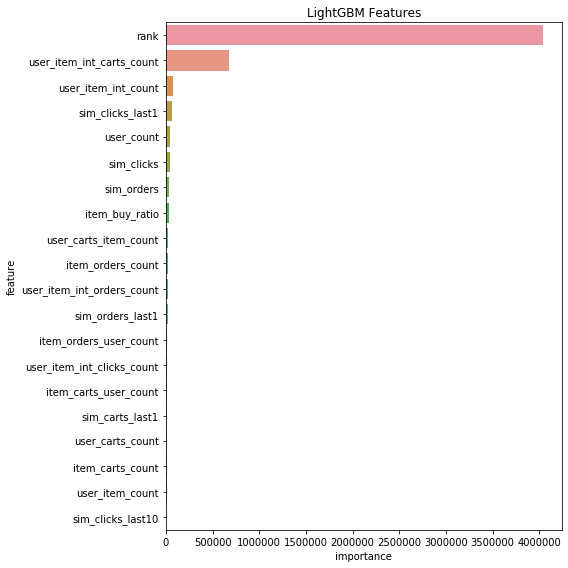

In [43]:
def print_gbm_model_feature_importance(model):
#     feature_names = model.feature_name()
    feature_names = features
#     importances = list(model.feature_importance())
    importances = list(model.feature_importances_)
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature", 
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [44]:
train.head()

,session,aid,rank,user_count,user_item_count,user_buy_ratio,user_clicks_count,user_clicks_item_count,user_carts_count,user_carts_item_count,...,sim_clicks,sim_carts,sim_orders,sim_clicks_last1,sim_carts_last1,sim_orders_last1,sim_clicks_last2,sim_clicks_last3,sim_clicks_last5,sim_clicks_last10
0,12899779,59625,0,1,1,1.0,1.0,1.0,NaN,NaN,...,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000
1,12899779,397451,1,1,1,1.0,1.0,1.0,NaN,NaN,...,0.952355,NaN,NaN,0.952355,NaN,NaN,0.952355,0.952355,0.952355,0.952355
2,12899779,469285,2,1,1,1.0,1.0,1.0,NaN,NaN,...,0.933419,NaN,NaN,0.933419,NaN,NaN,0.933419,0.933419,0.933419,0.933419
3,12899779,438191,3,1,1,1.0,1.0,1.0,NaN,NaN,...,0.753977,NaN,NaN,0.753977,NaN,NaN,0.753977,0.753977,0.753977,0.753977
4,12899779,731692,4,1,1,1.0,1.0,1.0,NaN,NaN,...,0.903594,NaN,NaN,0.903594,NaN,NaN,0.903594,0.903594,0.903594,0.903594


In [45]:
train.shape

(75693605, 35)

In [51]:
train_pred = train[['session','aid','rank']].copy()
train_pred['prob'] = oof_predictions
train_pred

,session,aid,rank,prob
0,12899779,59625,0,2.488987
1,12899779,397451,1,0.829854
2,12899779,469285,2,-0.618900
3,12899779,438191,3,-2.403424
4,12899779,731692,4,-0.489573
...,...,...,...,...
75693600,14571581,514866,36,-2.795200
75693601,14571581,1781934,37,-3.428119
75693602,14571581,1651467,38,-3.400384
75693603,14571581,206561,39,-4.400884


In [53]:
import gc
gc.collect()

6012

In [54]:
train_pred = train_pred.sort_values(by=['session','prob'],ascending=[True,False])
sub = train_pred.groupby('session')['aid'].apply(lambda x: list(x)[:20]).reset_index()
sub.columns = ['session','labels']
sub["labels"] = sub.labels.apply(lambda x: " ".join(map(str,x)))


In [55]:
sub['session_type'] = [str(xx)+f'_{t}' for xx in sub.session]
sub['type'] = t
sub

,session,labels,session_type,type
0,12899779,59625 397451 731692 469285 1790770 679602 4754...,12899779_orders,orders
1,12899780,1142000 736515 973453 582732 487136 889686 103...,12899780_orders,orders
2,12899781,199008 918667 57315 141736 194067 811084 3542 ...,12899781_orders,orders
3,12899782,740494 779477 562753 987399 1711180 127404 134...,12899782_orders,orders
4,12899783,1817895 255297 607638 1729553 198385 1754419 1...,12899783_orders,orders
...,...,...,...,...
1671798,14571577,1141710 1276792 1666114 86916 768043 631085 36...,14571577_orders,orders
1671799,14571578,519105 977826 1811714 815460 131032 822641 231...,14571578_orders,orders
1671800,14571579,739876 1750859 785544 832213 234586 857928 513...,14571579_orders,orders
1671801,14571580,202353 1314576 433425 1231403 891417 682237 35...,14571580_orders,orders


## 加载原始submission，替换order部分

In [56]:
subold = pd.read_csv('../input/otto-recommender-system/submission.csv')

subold['session'] = [int(xx.split('_')[0]) for xx in subold.session_type]
subold['type'] = [xx.split('_')[1] for xx in subold.session_type]
subold

,session_type,labels,session,type
0,12899779_carts,59625 397451 731692 469285 1790770 159257 1253...,12899779,carts
1,12899779_clicks,59625 1253524 737445 731692 1790770 94230 1660...,12899779,clicks
2,12899779_orders,59625 397451 731692 469285 1790770 1253524 448...,12899779,orders
3,12899780_carts,1142000 973453 582732 736515 487136 1502122 88...,12899780,carts
4,12899780_clicks,1142000 736515 973453 582732 487136 889686 150...,12899780,clicks
...,...,...,...,...
5015404,14571580_clicks,202353 1314576 433425 1231403 871658 679257 92...,14571580,clicks
5015405,14571580_orders,202353 1314576 433425 1231403 891417 356096 88...,14571580,orders
5015406,14571581_carts,1100210 1684953 462056 1401429 622489 1072049 ...,14571581,carts
5015407,14571581_clicks,1100210 1684953 462056 1401429 622489 1158237 ...,14571581,clicks


In [57]:
subnew = pd.concat([subold[subold.type!=t],sub]).reset_index(drop=True)

In [58]:
subnew.shape

(5015409, 4)

In [59]:
subold.shape

(5015409, 4)

In [60]:
subnew = subnew.sort_values(by=['session','type']).reset_index(drop=True)

In [61]:
subnew

,session_type,labels,session,type
0,12899779_carts,59625 397451 731692 469285 1790770 159257 1253...,12899779,carts
1,12899779_clicks,59625 1253524 737445 731692 1790770 94230 1660...,12899779,clicks
2,12899779_orders,59625 397451 731692 469285 1790770 679602 4754...,12899779,orders
3,12899780_carts,1142000 973453 582732 736515 487136 1502122 88...,12899780,carts
4,12899780_clicks,1142000 736515 973453 582732 487136 889686 150...,12899780,clicks
...,...,...,...,...
5015404,14571580_clicks,202353 1314576 433425 1231403 871658 679257 92...,14571580,clicks
5015405,14571580_orders,202353 1314576 433425 1231403 891417 682237 35...,14571580,orders
5015406,14571581_carts,1100210 1684953 462056 1401429 622489 1072049 ...,14571581,carts
5015407,14571581_clicks,1100210 1684953 462056 1401429 622489 1158237 ...,14571581,clicks


In [62]:
subnew[['session_type','labels']].to_csv('../sub/submission.csv',index=False) 


